In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST


import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preparing Data

In [3]:
batch_size = 64

In [4]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [5]:
train_dataset = MNIST(root="data/", train=True,
                      transform=data_transforms, download=True)
test_dataset = MNIST(root="data/", train=False,
                     transform=data_transforms, download=False)

train_loader = DataLoader(dataset=train_dataset,shuffle=True, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset,shuffle=False, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 141712350.98it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42743716.95it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37754826.68it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7251819.10it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Visualize example

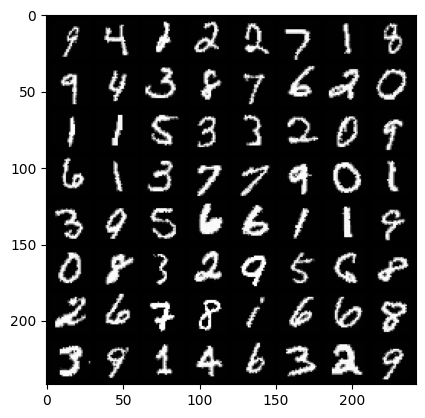

In [6]:
sample = iter(train_loader)
images, labels = next(sample)

def show(imgs_grid):
    imgs_grid = imgs_grid.detach()
    imgs_grid = F.to_pil_image(imgs_grid)
    
    plt.imshow(np.asarray(imgs_grid))
    plt.show()

image_grid = torchvision.utils.make_grid(images)

show(image_grid)

## Model

In [14]:
class AutoEncoder(nn.Module):
    def __init__(self, using_Conv=True):
        super(AutoEncoder, self).__init__()
        if using_Conv:
            self.encode = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),# N, 16, 14, 14
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),# N, 32, 7, 7
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=7) # N, 64, 1, 1
            )
            self.decode = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 7),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), #N, 16, 13, 13
                nn.ReLU(),
                nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),#N, 1, 28, 28
                nn.Sigmoid()
            )
        else:
            self.encode = nn.Sequential(
                nn.Linear(28*28, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 12),
                nn.ReLU(),
                nn.Linear(12, 3)
            )
            self.decode = nn.Sequential(
                nn.Linear(3, 12),
                nn.ReLU(),
                nn.Linear(12, 64),
                nn.ReLU(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 28*28),
                nn.Sigmoid()
            )
        
        
        
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        
        return decoded

## Training

In [8]:
epochs = 20
plot_steps = 1
lr = 1e-3

In [17]:
model = AutoEncoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=lr, weight_decay=1e-5)


In [22]:
n_totals_step = len(train_loader)
loss_his = []
image_outputs = []

for epoch in range(epochs):
    for idx, (images, labels) in enumerate(train_loader):
        # reshape images
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward 
        outputs = model(images).to(device)
        loss = criterion(outputs, images)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        # update parameters
        optimizer.step()
        
        loss_his.append(loss.item())
        image_outputs.append((epoch, outputs, images))
        
        if( idx + 1) % 100 == 0:
            print(f"epoch {epoch + 1} / {epochs}, step {idx+1}/{n_totals_step}, loss={loss.item():.4f}")

epoch 1 / 20, step 100/938, loss=0.8384
epoch 1 / 20, step 200/938, loss=0.8334
epoch 1 / 20, step 300/938, loss=0.8394
epoch 1 / 20, step 400/938, loss=0.8365
epoch 1 / 20, step 500/938, loss=0.8267
epoch 1 / 20, step 600/938, loss=0.8352
epoch 1 / 20, step 700/938, loss=0.8382
epoch 1 / 20, step 800/938, loss=0.8529
epoch 1 / 20, step 900/938, loss=0.8506
epoch 2 / 20, step 100/938, loss=0.8358
epoch 2 / 20, step 200/938, loss=0.8361
epoch 2 / 20, step 300/938, loss=0.8319
epoch 2 / 20, step 400/938, loss=0.8407
epoch 2 / 20, step 500/938, loss=0.8405
epoch 2 / 20, step 600/938, loss=0.8298
epoch 2 / 20, step 700/938, loss=0.8439
epoch 2 / 20, step 800/938, loss=0.8392
epoch 2 / 20, step 900/938, loss=0.8293
epoch 3 / 20, step 100/938, loss=0.8409
epoch 3 / 20, step 200/938, loss=0.8395
epoch 3 / 20, step 300/938, loss=0.8403
epoch 3 / 20, step 400/938, loss=0.8374
epoch 3 / 20, step 500/938, loss=0.8366
epoch 3 / 20, step 600/938, loss=0.8376
epoch 3 / 20, step 700/938, loss=0.8445


## Evaluating


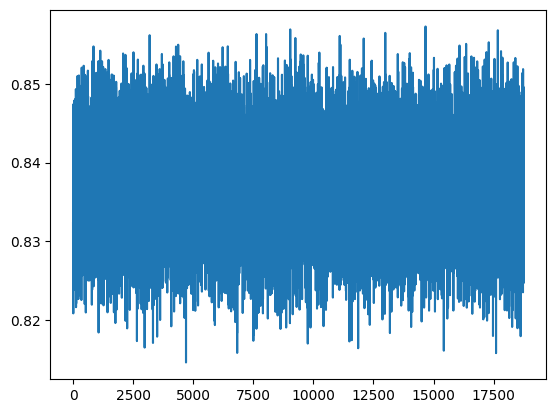

In [23]:
plt.plot(loss_his)
plt.show()

## Visualize Results

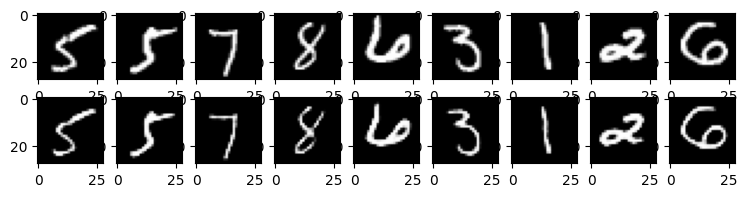

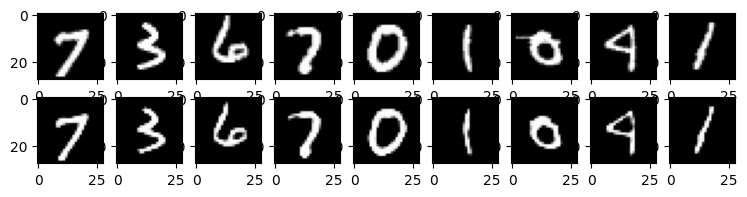

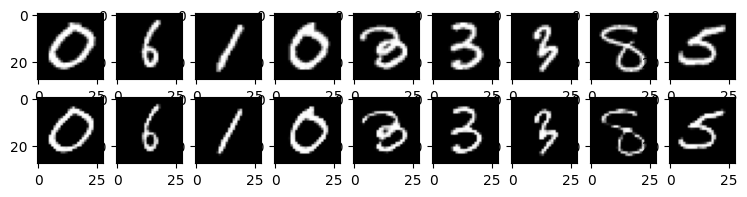

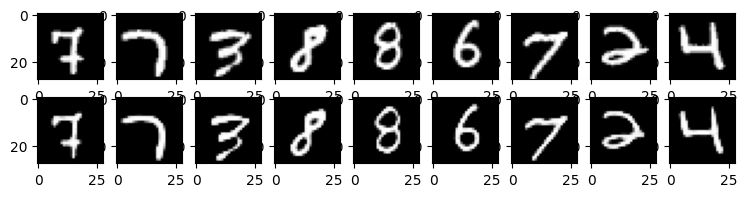

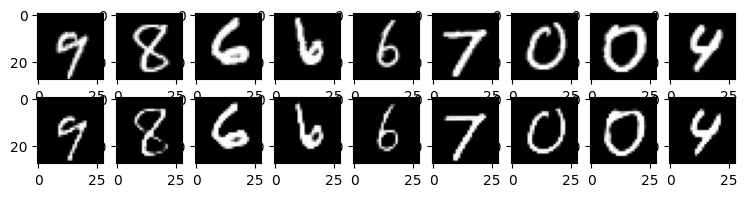

In [27]:
for k in range(0, epochs, 4):
  plt.figure(figsize=(9, 2))
  plt.gray()
  imgs = image_outputs[k][2].cpu().detach().numpy()
  recon = image_outputs[k][1].cpu().detach().numpy()
  for i, item in enumerate(imgs):
    if i >=9: break
    plt.subplot(2, 9, i+1)
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i >=9: break
    plt.subplot(2, 9, 9+i+1)
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

